# The bin bag challenge

For this challenge we:

- Discuss the models tested, their various trade-offs and our recommendation.
- Demonstrate our detection capabilities by showing off an alpha-classifier trained on a small amount of training data classifying the bags below.
- Discuss the next steps for getting this into production with First Mile.

<p align="center">
  <img src=general.jpg width="250" alt="Image 1">
  <img src=compostable.jpg width="250" alt="Image 2">
  <img src=mixed_recycle.jpg width="250" alt="Image 3">
</p>

<p align="center">
  <em>General Waste | Compostable Waste | Mixed Recycling</em>
</p>



## Classification models

2 types of models were trained for this challenge:
1. A K-nearest-neighbour (KNN) classifier.
2. A convolutional neural network (CNN) classifier.

Both models are tested on a held out dataset to compare the accuracy of the different models. We use accuracy as our goal in this challenge. There are  other metrics we could look at in future such as precision/recall - which would be useful going into a production setting.

### KNN Classifier

#### Highlights

- Accuracy = `0.75`
- Provides a baseline
- Uses colour histogram feature vectors
- Model size scales poorly for larger training sets
- Requires an object detector in practice

Our KNN classifier sets the baseline for this challenge. It was designed to be as simple as possible to set a baseline for future models. We achieved a classification accuracy of 0.75. It utilises a set of hand-crafted features based on a colour histogram of the plastic bags (a feature is a list of numbers representing the information stored in the image). We use the brute force search algorithm for accuracy given the small number of training and test samples. In practice in production we would use the KD-tree algorithm for small feature vectors, and the ball tree algorithm for larger feature vectors to improve the speed of search.

A negative of this model is that it stores the feature vector of every training image. As this moves into production and more training data is collected this scales poorly. Another issue is that in more complex scenes it would require an object detector.

### CNN Classifier

#### Highlights

- Accuracy = `0.90`
- Continuous training and improvement
- Model size remains constant for larger training sets
- Requires an object detector in practice, however this can be incorporated into the same model
- Better generalisability
- Generally requires more training data for good results

Our CNN classifier is harder to setup and train. But it provides scope for continuous training and model improvement in production. We achieved a classification accuracy of 0.90. It requires an object detector to be run first. This is because having the object centered in the image improves the learning process. It also ensures the classifier doesn't focus on other objects in the scene.

Whereas the KNN classifier scales poorly for larger training sets, the model size is fixed (unless its found greater model capacity is required to increase accuracy). In practice this model will generalise better to data outside of the captured test/train set - although we will need to capture more data working with you to prove that case.

### Recommendation

The CNN performs the best. It scales better as the training set size grows, and can be finetuned for continuous improvement as we find cases that are missed without complete retraining.

## Demonstration

In the demonstration we will:
* Import some libraries.
* Explain the training process of our CNN-based classifier.
* Demonstrate the use of cropping to improve accuracy.
* Show the results.

## Imports

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

from recycle_eye.notebook.utils import get_nn_run, get_accuracy_df, get_loss_df, imshow
from recycle_eye.paths import STATS_DIR, DATA_DIR, MODEL_DIR
from recycle_eye.classifier.dataloader import (
    BagDataset, basic_transform
)

## Training parameters

We show the results from experiment with ID `20231129-10:08:38`. First we show the training parameters used for the experiment.

The model is trained for 50 epochs across the training data, with a learning rate of 0.005 using stochastic gradient descent. The neural network contains 2 convolutional layers and 3 fully connected layers - so its extremely small by modern deep learning standards (only 244KB).

In [2]:
exp_id = "20231129-10:08:38"
df, params = get_nn_run(exp_id, STATS_DIR)
print(params)

id='20231129-10:08:38' split_seed=42 test_split=0.2 remove_bg=False lr=0.005 batch_size=4 optimiser=<OptimiserType.SGD: 'sgd'> momentum=0.9 num_epochs=50 data_counts=[DataCount(ord_label=0, label='compostable_waste', count=44), DataCount(ord_label=1, label='general_waste', count=51), DataCount(ord_label=2, label='mixed_recycling', count=51)] num_iter_per_epoch=30 load_cifar_weights=False transform=<TransformType.BASIC: 'basic'> pretrained_model=None crop_image=True


### Loss curve

The loss curve demonstrates the learning process. The model outputs the probability of each bag being the correct type. It learns (updates its parameters) by optimising a loss function called cross entropy which compares the probabilities to the ground truth labels. The idea is for it to output zero for the wrong classes, and one for the correct class.

As it trains and gets more objects correct classified the loss value goes down.

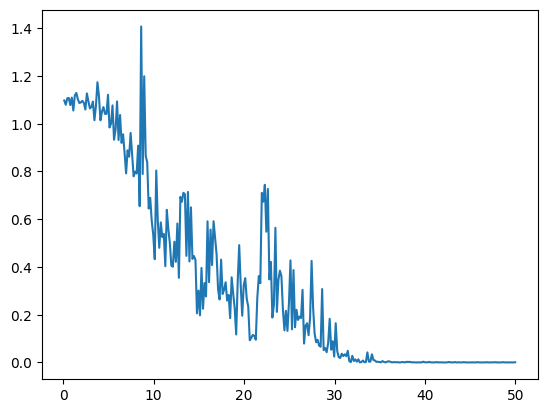

In [3]:
loss_df = get_loss_df(df, params)
plt.plot(loss_df.cont_epoch, loss_df.avg_loss)

### Accuracy against the test set

At the end of each epoch we cross validate (run the model against a held out test set, and check the accuracy score). This can be shown below.

As the loss goes down we see that the model performs better on data its never seen.

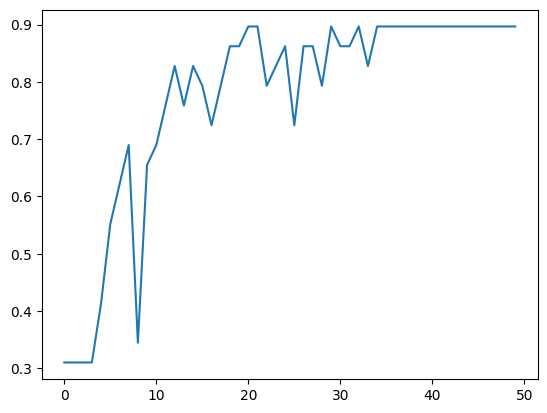

In [4]:
accuracy_df = get_accuracy_df(df)
plt.plot(accuracy_df["epoch"], accuracy_df["accuracy"])

## Preparing the data - use of cropping

Below we demonstrate the data shown to our model. For this challenge we were able to utilise the background images provided to find the bounding boxes. In practice we would use our object detectors to perform this action.

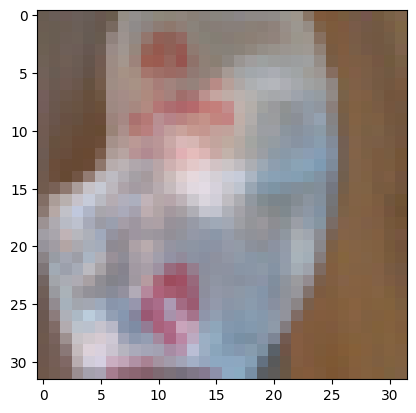

In [5]:
dataset = BagDataset(
    root_dir=str(DATA_DIR), transform=basic_transform(), crop_image=True
)

for image, _, _ in dataset:
    clear_output(wait=True)
    imshow(image)

## The results

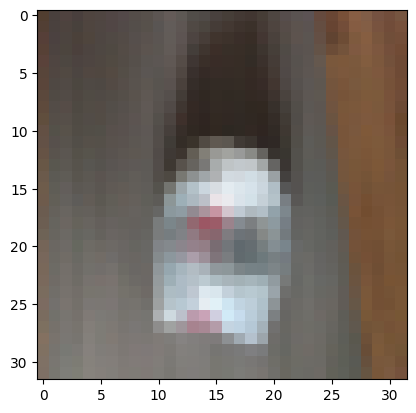

'Truth = mixed_recycling, predicted = general_waste, Wrong'

In [6]:
import torch

from recycle_eye.classifier.train import get_datasets
from recycle_eye.classifier.basic_network import Net

# We only care about the test set here
_ ,test_set = get_datasets(params, basic_transform)

# Load in the model
net = Net()
model_path = MODEL_DIR / exp_id / "final_bag_net.pth"
net.load_state_dict(torch.load(model_path))

label_map = {count.ord_label: count.label for count in params.data_counts}

correct = 0
total = 0
with torch.no_grad():
    for data in test_set:
        image, label, _ = data

        # image display
        time.sleep(1)
        clear_output(wait=True)
        imshow(image)
        
        # calculate outputs by running images through the network
        output = net(torch.unsqueeze(image, 0))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(output.data, 1)

        # add to the scores
        total += 1
        gt = label
        predicted = predicted.item()
        is_correct = predicted == gt
        correct += int(is_correct)

        display_str = f"Truth = {label_map[gt]}, predicted = {label_map[predicted]}, {'Correct' if is_correct else 'Wrong'}"
        display(display_str)


accuracy = correct / total


In [7]:
display(f"Test images {total}, correct {correct}, accuracy {accuracy}")

'Test images 29, correct 26, accuracy 0.896551724137931'